<a href="https://colab.research.google.com/github/uzair011/CN6022/blob/main/Unsupervised_CN6022.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Install PySpark
!pip install pyspark

# Import necessary libraries
from pyspark.sql import SparkSession
from pyspark.ml.clustering import KMeans
from pyspark.ml.feature import VectorAssembler, StandardScaler, PCA, Imputer
from pyspark.ml.evaluation import ClusteringEvaluator
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


In [2]:
# Initialize Spark session
spark = SparkSession.builder.appName("KMeansClusteringLab").getOrCreate()


In [4]:
# Load the dataset
data_path = "/content/diabetes (3).csv"  # Update this path to your dataset location
dataset = spark.read.csv(data_path, header=True, inferSchema=True)

# Preview the data
dataset.show(5)


+------+--------+---------+---+------+------+--------------------+------------+------+-------+-----------------+-------------+-----------+-------+--------+--------+--------+---+---+---------+------+--------+
|HighBP|HighChol|CholCheck|BMI|Smoker|Stroke|HeartDiseaseorAttack|PhysActivity|Fruits|Veggies|HvyAlcoholConsump|AnyHealthcare|NoDocbcCost|GenHlth|MentHlth|PhysHlth|DiffWalk|Sex|Age|Education|Income|Diabetes|
+------+--------+---------+---+------+------+--------------------+------------+------+-------+-----------------+-------------+-----------+-------+--------+--------+--------+---+---+---------+------+--------+
|     1|       1|        1| 40|     1|     0|                   0|           0|     0|      1|                0|            1|          0|      5|      18|      15|       1|  0|  9|        4|     3|       0|
|     0|       0|        0| 25|     1|     0|                   0|           1|     0|      0|                0|            0|          1|      3|       0|       0|    

In [5]:
# Print schema to understand data types
dataset.printSchema()

# Summary statistics
dataset.describe().show()


root
 |-- HighBP: integer (nullable = true)
 |-- HighChol: integer (nullable = true)
 |-- CholCheck: integer (nullable = true)
 |-- BMI: integer (nullable = true)
 |-- Smoker: integer (nullable = true)
 |-- Stroke: integer (nullable = true)
 |-- HeartDiseaseorAttack: integer (nullable = true)
 |-- PhysActivity: integer (nullable = true)
 |-- Fruits: integer (nullable = true)
 |-- Veggies: integer (nullable = true)
 |-- HvyAlcoholConsump: integer (nullable = true)
 |-- AnyHealthcare: integer (nullable = true)
 |-- NoDocbcCost: integer (nullable = true)
 |-- GenHlth: integer (nullable = true)
 |-- MentHlth: integer (nullable = true)
 |-- PhysHlth: integer (nullable = true)
 |-- DiffWalk: integer (nullable = true)
 |-- Sex: integer (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Education: integer (nullable = true)
 |-- Income: integer (nullable = true)
 |-- Diabetes: integer (nullable = true)

+-------+-------------------+------------------+------------------+-----------------

In [7]:
dataset.filter(dataset["HighBP"].isNull()).show()


+------+--------+---------+---+------+------+--------------------+------------+------+-------+-----------------+-------------+-----------+-------+--------+--------+--------+---+---+---------+------+--------+
|HighBP|HighChol|CholCheck|BMI|Smoker|Stroke|HeartDiseaseorAttack|PhysActivity|Fruits|Veggies|HvyAlcoholConsump|AnyHealthcare|NoDocbcCost|GenHlth|MentHlth|PhysHlth|DiffWalk|Sex|Age|Education|Income|Diabetes|
+------+--------+---------+---+------+------+--------------------+------------+------+-------+-----------------+-------------+-----------+-------+--------+--------+--------+---+---+---------+------+--------+
+------+--------+---------+---+------+------+--------------------+------------+------+-------+-----------------+-------------+-----------+-------+--------+--------+--------+---+---+---------+------+--------+



In [8]:
null_count = dataset.filter(dataset["HighBP"].isNull()).count()
print(f"Number of null values in 'HighBP' column: {null_count}")

Number of null values in 'HighBP' column: 0


In [10]:
df2 = spark.createDataFrame(dataset, ["HighBP", "HighChol", "CholCheck", "BMI", "Smoker", "Stroke", "HeartDiseaseorAttack", "PhysActivity", "Fruits", "Veggies", "HvyAlcoholConsump", "AnyHealthcare", "NoDocbcCost", "GenHlth", "MentHlth", "PhysHlth", "DiffWalk", "Sex", "Age", "Education", "Income", "Diabetes"])

# Count null values in each column
null_counts = df2.select([_sum(col(c).isNull().cast("int")).alias(c) for c in df2.columns])

 # Convert to Pandas DataFrame for plotting
null_counts_pd = null_counts.toPandas()

# Melt the DataFrame for easier plotting with Seaborn
null_counts_pd_melted = null_counts_pd.melt(var_name="Column", value_name="Null Values")

# Plot the results plt.figure(figsize=(10, 6))
sns.barplot(data=null_counts_pd_melted, x="Column", y="Null Values")
plt.title("Number of Null Values in Each Column")
plt.show()

PySparkTypeError: [SHOULD_NOT_DATAFRAME] Argument `data` should not be a DataFrame.


Data Cleaning and Imputation



In [11]:
# Data Cleaning: Replace zero values with NaN in specific columns
from pyspark.sql.functions import when

# Columns where zero is invalid and should be replaced by NaN
columns_with_zeros = ["HighBP", "BMI", "PhysActivity"] # -----------> example, repalce as needed

# Replace zeros with NaN
for col_name in columns_with_zeros:
    dataset = dataset.withColumn(col_name, when(dataset[col_name] == 0, np.nan).otherwise(dataset[col_name]))

# Impute missing values with column mean
imputer = Imputer(inputCols=columns_with_zeros, outputCols=[f"{col}_imputed" for col in columns_with_zeros])
dataset = imputer.fit(dataset).transform(dataset)


Assemble and Standardize Features




In [12]:
# Assemble the features for clustering
# Update with all columns that should be used for clustering, including imputed ones
feature_cols = [f"{col}_imputed" for col in columns_with_zeros] + ["Age", "Income"]  # Add other relevant columns here and see results
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
dataset = assembler.transform(dataset)

# Standardize the features
scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures", withMean=True, withStd=True)
scaler_model = scaler.fit(dataset)
dataset = scaler_model.transform(dataset)


Determine Optimal Number of Clusters (Elbow Method)
python
Copy code


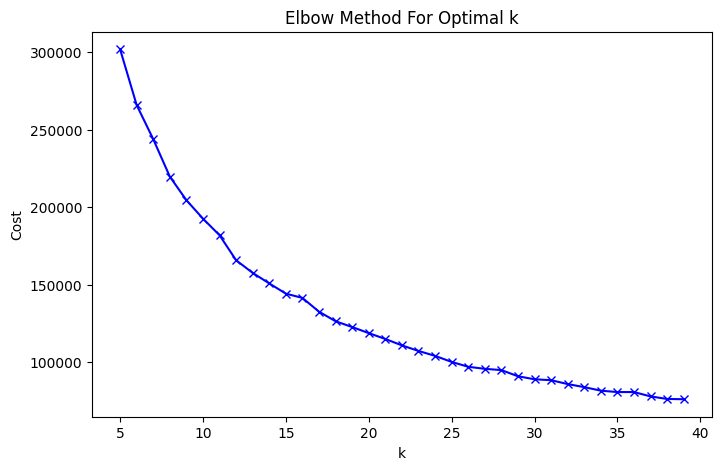

In [13]:
# Use the Elbow Method to determine the optimal number of clusters

#TODO:  it mgith take some time, try chnaging various values of K range (min, max) and see what happens,

cost = []
#k_values = list(range(2, 20))

k_values = list(range(5, 40))

for k in k_values:
    kmeans = KMeans(featuresCol="scaledFeatures", k=k, seed=1)
    model = kmeans.fit(dataset)
    cost.append(model.summary.trainingCost)

# Plot the elbow curve
plt.figure(figsize=(8, 5))
plt.plot(k_values, cost, 'bx-')
plt.xlabel('k')
plt.ylabel('Cost')
plt.title('Elbow Method For Optimal k')
plt.show()



Train K-Means Model



In [ ]:
# Choose optimal k (based on Elbow Method, assume k=30 for this example)
optimal_k = 30 # Exaple, repalce as needed

kmeans = KMeans(featuresCol="scaledFeatures", k=optimal_k, seed=1)
model = kmeans.fit(dataset)
predictions = model.transform(dataset)


Evaluate the Model (Silhouette Score)


In [ ]:
# Calculate silhouette score to evaluate the clustering
evaluator = ClusteringEvaluator(featuresCol="scaledFeatures", metricName='silhouette', distanceMeasure='squaredEuclidean')
silhouette = evaluator.evaluate(predictions)
print(f"Silhouette Score: {silhouette}")


Silhouette Score: 0.3800913084454426


Analyze Cluster Centers

In [ ]:
# Display the coordinates of each cluster center
centers = model.clusterCenters()
print("Cluster Centers:")
for center in centers:
    print(center)

    '''
Each cluster center represents the "average" profile of data points within a cluster across all features. Here's what it tells us:

Interpretation: Each row in the cluster centers represents one cluster, and each value in the row corresponds to the average value of a
feature within that cluster. For example, a high positive or negative value in a specific feature indicates a strong characteristic
of that cluster.'''



Cluster Centers:
[0.         1.56503432 0.         0.25670136 0.48957053]
[ 0.         -0.78621572  0.         -1.73218016 -0.40623431]
[ 0.          0.62364268  0.          0.71107872 -0.39577802]
[ 0.         -0.63637215  0.          0.05554223 -2.21876902]
[ 0.         -0.03567785  0.          0.15380241  0.7882131 ]
[ 0.         -0.2068747   0.         -0.62834402  0.82252088]
[ 0.         -0.03812579  0.          1.35209066 -0.49778723]
[ 0.          2.91459265  0.         -0.23459116  0.29509339]
[ 0.         -0.60421348  0.          0.01968443 -1.09159265]
[ 0.         -0.21022678  0.          0.92562481  0.76423175]
[ 0.          1.31159705  0.         -1.21128492 -1.62885866]
[ 0.         -0.99964909  0.          1.32559558 -1.01852607]
[ 0.          7.95276885  0.         -0.4167987   0.15989278]
[ 0.         -0.49600933  0.         -1.66118101 -1.91713477]
[ 0.          2.85983994  0.         -0.25412472 -1.78763106]
[0.         0.61730803 0.         0.7635221  0.74463358]
[

Visualize Clusters Using PCA

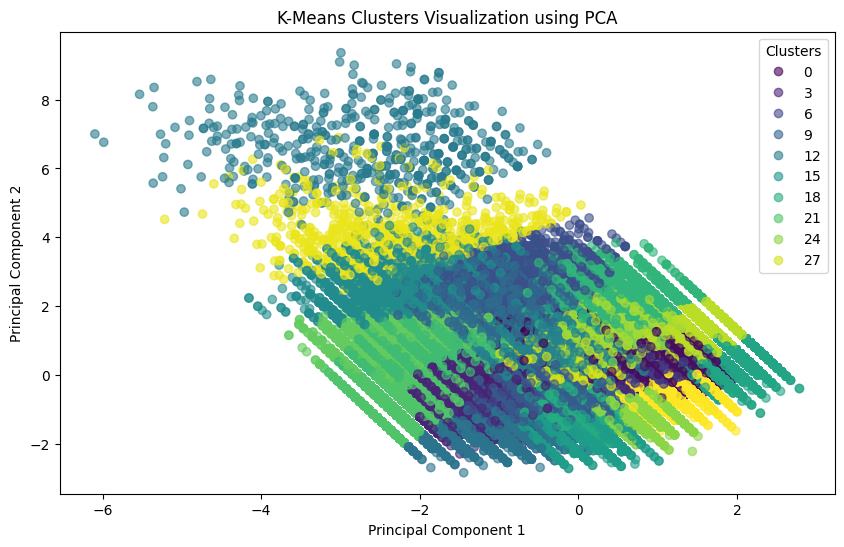

In [ ]:
# Reduce dimensionality for visualization using PCA
pca = PCA(k=2, inputCol="scaledFeatures", outputCol="pcaFeatures")
pca_model = pca.fit(predictions)
predictions_pca = pca_model.transform(predictions)

# Convert to Pandas DataFrame for plotting
pandas_df = predictions_pca.select("pcaFeatures", "prediction").toPandas()
pandas_df['pca_x'] = pandas_df['pcaFeatures'].apply(lambda x: x[0])
pandas_df['pca_y'] = pandas_df['pcaFeatures'].apply(lambda x: x[1])

# Plot clusters
plt.figure(figsize=(10, 6))
scatter = plt.scatter(pandas_df['pca_x'], pandas_df['pca_y'], c=pandas_df['prediction'], cmap='viridis', alpha=0.6)
plt.title('K-Means Clusters Visualization using PCA')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(*scatter.legend_elements(), title="Clusters")
plt.show()


summary


In [ ]:
# Summary of K-Means Clustering
print("Summary of K-Means Clustering:")
print("Optimal number of clusters (k):", optimal_k)
print("Silhouette Score:", silhouette)
print("Cluster Centers:")
for i, center in enumerate(centers):
    print(f"Cluster {i+1} Center: {center}")


Summary of K-Means Clustering:
Optimal number of clusters (k): 30
Silhouette Score: 0.3800913084454426
Cluster Centers:
Cluster 1 Center: [0.         1.56503432 0.         0.25670136 0.48957053]
Cluster 2 Center: [ 0.         -0.78621572  0.         -1.73218016 -0.40623431]
Cluster 3 Center: [ 0.          0.62364268  0.          0.71107872 -0.39577802]
Cluster 4 Center: [ 0.         -0.63637215  0.          0.05554223 -2.21876902]
Cluster 5 Center: [ 0.         -0.03567785  0.          0.15380241  0.7882131 ]
Cluster 6 Center: [ 0.         -0.2068747   0.         -0.62834402  0.82252088]
Cluster 7 Center: [ 0.         -0.03812579  0.          1.35209066 -0.49778723]
Cluster 8 Center: [ 0.          2.91459265  0.         -0.23459116  0.29509339]
Cluster 9 Center: [ 0.         -0.60421348  0.          0.01968443 -1.09159265]
Cluster 10 Center: [ 0.         -0.21022678  0.          0.92562481  0.76423175]
Cluster 11 Center: [ 0.          1.31159705  0.         -1.21128492 -1.62885866]
Clu

<ipython-input-31-344da0d0a10b>:31: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bx-" (-> color='b'). The keyword argument will take precedence.
  ax1.plot(k_values, cost, 'bx-', label='Cost (Elbow Method)', color='blue')
<ipython-input-31-344da0d0a10b>:38: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "rx-" (-> color='r'). The keyword argument will take precedence.
  ax2.plot(k_values, silhouette_scores, 'rx-', label='Silhouette Score', color='red')


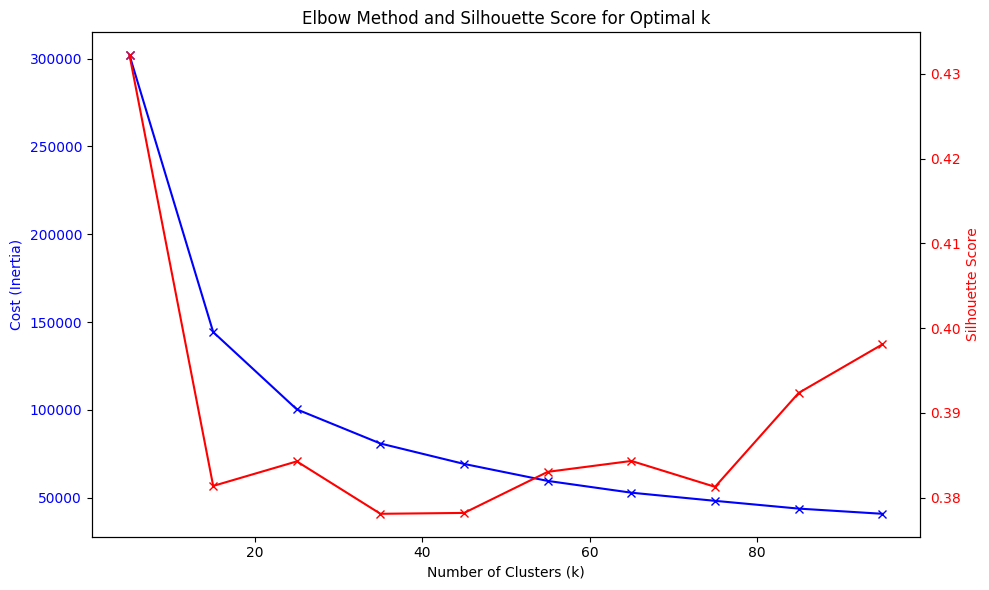

'\n Elbow Method (Cost/Inertia)\nDefinition: The Elbow Method measures the cost or inertia, which is the sum of squared distances between each data point and its assigned cluster center\n\n Silhouette Score\nDefinition: The Silhouette Score measures how similar each data point is to its assigned cluster (cohesion) compared to other clusters (separation).\n\n\nUsing Both Metrics Together\nElbow Method: Helps understand how well the data points fit within clusters based on cost.\nSilhouette Score: Helps validate how well-separated and cohesive the clusters are.\n\nBy combining these insights, you’ll be able to select an optimal k that creates clusters with both minimal cost and high cohesion\n\n'

In [ ]:
#############Optional ###############

# Lists to store cost and silhouette scores for each k
cost = []
silhouette_scores = []
k_values = list(range(5, 100, 10)) #range(start, stop, step)

from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator

# Loop through values of k
for k in k_values:
    kmeans = KMeans(featuresCol="scaledFeatures", k=k, seed=1)
    model = kmeans.fit(dataset)

    # Calculate cost (training cost or within-cluster sum of squares)
    cost.append(model.summary.trainingCost)

    # Predict clusters
    predictions = model.transform(dataset)

    # Calculate silhouette score
    evaluator = ClusteringEvaluator(featuresCol="scaledFeatures", metricName='silhouette', distanceMeasure='squaredEuclidean')
    silhouette = evaluator.evaluate(predictions)
    silhouette_scores.append(silhouette)

# Plot both cost (Elbow Method) and Silhouette Score
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot Elbow Method (Cost) on the primary y-axis
ax1.plot(k_values, cost, 'bx-', label='Cost (Elbow Method)', color='blue')
ax1.set_xlabel('Number of Clusters (k)')
ax1.set_ylabel('Cost (Inertia)', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Plot Silhouette Score on the secondary y-axis
ax2 = ax1.twinx()
ax2.plot(k_values, silhouette_scores, 'rx-', label='Silhouette Score', color='red')
ax2.set_ylabel('Silhouette Score', color='red')
ax2.tick_params(axis='y', labelcolor='red')

# Add titles and legend
plt.title('Elbow Method and Silhouette Score for Optimal k')
fig.tight_layout()
plt.show()


'''
 Elbow Method (Cost/Inertia)
Definition: The Elbow Method measures the cost or inertia, which is the sum of squared distances between each data point and its assigned cluster center

 Silhouette Score
Definition: The Silhouette Score measures how similar each data point is to its assigned cluster (cohesion) compared to other clusters (separation).


Using Both Metrics Together
Elbow Method: Helps understand how well the data points fit within clusters based on cost.
Silhouette Score: Helps validate how well-separated and cohesive the clusters are.

By combining these insights, you’ll be able to select an optimal k that creates clusters with both minimal cost and high cohesion

might be here 90-100 is better choice

'''